In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import simon_64_128
import simon_64_128_simulation
import correlations
import helper

from helper import KeyHypothesis
from measurement import Measurements

In [ ]:
rng = np.random.default_rng()

NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45
CORR_DIFF_THRESHOLD = 0.05

# Perform Simulated Measurements with random plaintexts

In [3]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)
print(helper.array_to_hex_str(key))

0x1BDB4BA8 0x2264266E 0xBDEA6366 0xC88D60E2


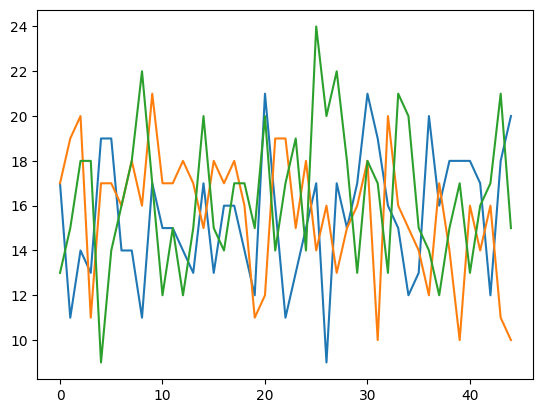

In [4]:
 # Perform 1000 simulated measurements
plaintexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((NUM_MEASUREMENTS, VALS_PER_MEASUREMENT), dtype=np.uint32)


for i in range(NUM_MEASUREMENTS):
    pt = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ct, log = simon_64_128.encrypt_block(pt, key)
    power = simon_64_128_simulation.log_to_simulated_power(log)

    plaintexts[i] = pt
    ciphertexts[i] = ct
    powers[i, :] = power

measurements = Measurements(plaintexts, ciphertexts, powers)

# Draw 3 simulated traces
plt.figure()
plt.plot(measurements[0].power)
plt.plot(measurements[1].power)
plt.plot(measurements[2].power)
plt.show()


# Simulated Measurement for 3 specific plaintexts

The graph shows that a plaintext of [FFFFFFFF, FFFFFFFF] will result in a high power consumption at the beginning. The plaintext [00000000, 00000000] has a low power consumption at the beginning.

In the beginning, the plaintexts [00000000, 00000000] and [00000001, 00000000] have a similar graph.

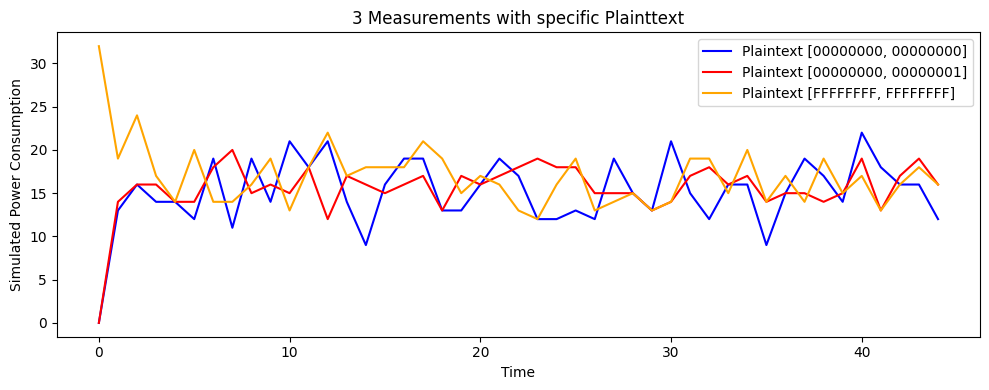

In [5]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = simon_64_128_simulation.log_to_simulated_power(log1)
current_consumption2 = simon_64_128_simulation.log_to_simulated_power(log2)
current_consumption3 = simon_64_128_simulation.log_to_simulated_power(log3)

plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

# Attack

In [41]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    helper.calc_corrs_for_hypos(sub_hypos, measurements)
    promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        print(f"{helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")


Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000044: correlation: -0.4937492165993802
0x00000000 0x00000000 0x00000000 0x000000BB: correlation: 0.49374921659938037
Perform Attack Step 2/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x0000C444: correlation: -0.6928216686743905
0x00000000 0x00000000 0x00000000 0x00003BBB: correlation: 0.6928216686743903
Perform Attack Step 3/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x001CC444: correlation: -0.862918085388624
0x00000000 0x00000000 0x00000000 0x00E33BBB: correlation: 0.862918085388624
Perform Attack Step 4/16
Find correlations for 512 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x331CC444: correlation: -1.0
0x00000000 0x00000000 0x00000000 0xCCE33BBB: correlation: 1.0
Perform Attack Step 5/16
Find correlati

In [42]:
print(f"Actual key:     {helper.array_to_hex_str(key)}")
print(f"Extracted key:  {helper.array_to_hex_str(extracted_key)}")
print(f"Differences:    {helper.array_to_hex_str(extracted_key ^ key)}")

Actual key:     0x1DF2BE79 0xCD033AA0 0x08636361 0xCCE33BBB
Extracted key:  0x1DF2BE79 0xCD033AA0 0x08636361 0xCCE33BBB
Differences:    0x00000000 0x00000000 0x00000000 0x00000000


# Attack Insights

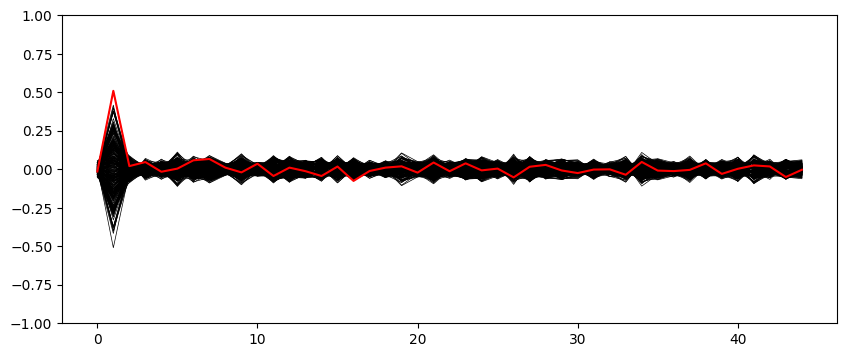

Correct byte: [ 467356584  576988782 3186254694 3364708578]


In [6]:
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)

corrs = correlations.calc_corrs(expected_hws, measurements.power)

correct_byte = key[3] & 0xFF

plt.figure(figsize=(10,4))
for i in range(256):

    plt.plot(corrs[i], color="black", linewidth=0.5)

plt.plot(corrs[correct_byte], color="red")

plt.ylim(-1, 1)
plt.show()
print(f"Correct byte: {key}")

# Attack insights
Correlation depending on number of traces

In [7]:
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)
print(expected_hws.shape)

corrs = correlations.Corr((256,VALS_PER_MEASUREMENT))

di = 50
best_corrs_over_num_measurements = np.zeros((256,NUM_MEASUREMENTS//di), dtype=np.float64)

n = 10
for i in range(0,NUM_MEASUREMENTS, n):
    corrs.update(expected_hws[i:i+n,:], measurements.power[i:i+n,:]) 
    if i % di == 0:
        idx = i // di
        best_corrs_over_num_measurements[:, idx] = corrs.max(axis=1)


(1000, 256)


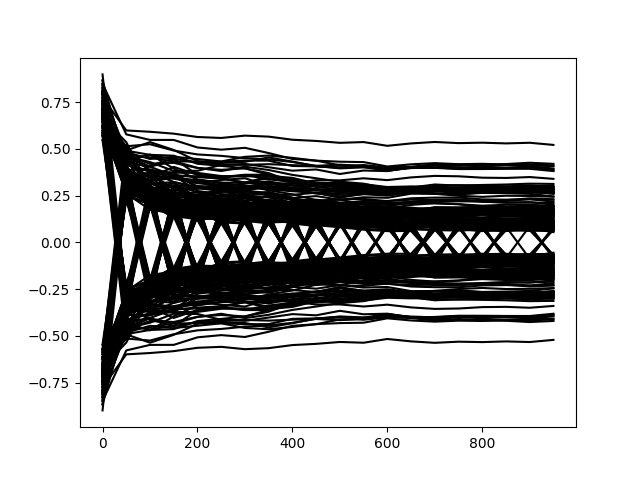

In [8]:
%matplotlib widget

plt.figure()
x = np.arange(0, NUM_MEASUREMENTS, step=di)

correct_byte = int(key[3] & 0xFF)

for i in range(256):
    plt.plot(x, best_corrs_over_num_measurements[i], color="black")

plt.show()